# Disaster Tweets Classification using RoBERTa

In [26]:
%pip install -U accelerate
%pip install transformers
%pip install transformers[torch]
%pip install spacy
%pip install unidecode
%pip install datasets
%pip install wandb
%pip install seaborn
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
import spacy
import re
import pandas as pd
from unidecode import unidecode
import wandb
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data = pd.read_csv('../data/train.csv')
texts = data['text'].to_list()
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

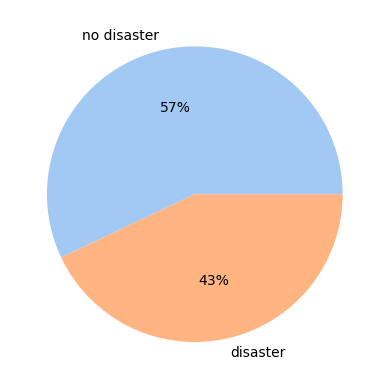

In [33]:
plt.pie(data['target'].value_counts(), labels = ['no disaster', 'disaster'], colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.show()

In [5]:
texts[:30]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
def clean_text(texts):
    clean_texts = []
    for text in nlp.pipe(texts):
    #     clean_texts.append(" ".join([token.text.strip("#").lower() for token in text if not token.is_punct]))
        sen = []
        for t in text:
            if t.is_punct:
                continue
            t = '@user' if t.text.startswith('@') and len(t) > 1 else t.text
            t = 'http' if t.startswith('http') else t
            sen.append(t.strip('#').lower())
        clean_texts.append(" ".join(sen))
        #     print(sen)
        #     print([(token,token.is_punct) for token in text])
        #     clean_texts = [unidecode(re.sub(r"http\S+", "", text).strip()) for text in clean_texts]
    
    return clean_texts

data["final_text"] = clean_text(texts)

In [8]:
data

,id,keyword,location,text,target,final_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@user @user the out of control wild fires in c...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 01:04 utc]?5 km s of volcano hawaii http
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...


In [9]:
# Loading the Hugging Face pretrained sequence classification model
model_name='cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
df = pd.DataFrame()
df['labels'] = data['target']
df['text'] = data['final_text']

In [11]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [12]:
train_ds = Dataset.from_pandas(df_train, split='train')
val_ds = Dataset.from_pandas(df_val, split='test')

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
def preprocess_function(inp):
    return tokenizer(inp['text'], truncation=True)

In [15]:
train_ds_tk = train_ds.map(preprocess_function, batched=True)
val_ds_tk = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [16]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    label = pred.label_ids
    preds = pred.predictions.argmax(-1)
    prec, rec, f1, _ = precision_recall_fscore_support(label, preds, average='binary')
    acc = accuracy_score(label, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': prec,
        'recall': rec
    }

In [17]:
# Model training on Train dataset and performance on Validation dataset
training_args = TrainingArguments(
    output_dir="./results",         # set output directory
    learning_rate=1e-5,             # we can customize learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="wandb",              # enable logging to W&B
    logging_strategy='steps',
    logging_steps=100,              # we will log every 100 steps
    evaluation_strategy='steps',    # check evaluation metrics on a given # of steps
    eval_steps=100,                 # we will perform evaluation every 100 steps
    eval_accumulation_steps=1,      # report evaluation results after each step
    metric_for_best_model='f1',
    load_best_model_at_end=False
)

# automatically log model to W&B at the end
%env WANDB_LOG_MODEL=true

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tk,
    eval_dataset=val_ds_tk,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
wandb.finish()

env: WANDB_LOG_MODEL=true


/Users/tarunbirgambhir/miniforge3/envs/tensorflow/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: tarun0131. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3810 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.5221, 'learning_rate': 9.73753280839895e-06, 'epoch': 0.26}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.41366469860076904, 'eval_accuracy': 0.8181221273801708, 'eval_f1': 0.792198049512378, 'eval_precision': 0.7868852459016393, 'eval_recall': 0.797583081570997, 'eval_runtime': 21.4381, 'eval_samples_per_second': 71.042, 'eval_steps_per_second': 4.478, 'epoch': 0.26}
{'loss': 0.407, 'learning_rate': 9.4750656167979e-06, 'epoch': 0.52}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.39615365862846375, 'eval_accuracy': 0.8233749179251477, 'eval_f1': 0.7796887796887797, 'eval_precision': 0.851520572450805, 'eval_recall': 0.7190332326283988, 'eval_runtime': 20.054, 'eval_samples_per_second': 75.945, 'eval_steps_per_second': 4.787, 'epoch': 0.52}
{'loss': 0.4112, 'learning_rate': 9.212598425196852e-06, 'epoch': 0.79}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.39116591215133667, 'eval_accuracy': 0.8332239001969797, 'eval_f1': 0.8018720748829954, 'eval_precision': 0.8290322580645161, 'eval_recall': 0.7764350453172205, 'eval_runtime': 19.9206, 'eval_samples_per_second': 76.453, 'eval_steps_per_second': 4.819, 'epoch': 0.79}
{'loss': 0.4015, 'learning_rate': 8.9501312335958e-06, 'epoch': 1.05}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4279293119907379, 'eval_accuracy': 0.8365068942875903, 'eval_f1': 0.808608762490392, 'eval_precision': 0.8231611893583725, 'eval_recall': 0.7945619335347432, 'eval_runtime': 21.2773, 'eval_samples_per_second': 71.579, 'eval_steps_per_second': 4.512, 'epoch': 1.05}
{'loss': 0.3674, 'learning_rate': 8.687664041994751e-06, 'epoch': 1.31}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.40075284242630005, 'eval_accuracy': 0.8404464871963231, 'eval_f1': 0.8091123330714847, 'eval_precision': 0.8428805237315876, 'eval_recall': 0.7779456193353474, 'eval_runtime': 21.4671, 'eval_samples_per_second': 70.946, 'eval_steps_per_second': 4.472, 'epoch': 1.31}
{'loss': 0.3465, 'learning_rate': 8.4251968503937e-06, 'epoch': 1.57}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.38577207922935486, 'eval_accuracy': 0.8384766907419566, 'eval_f1': 0.8072100313479623, 'eval_precision': 0.8387622149837134, 'eval_recall': 0.7779456193353474, 'eval_runtime': 21.4933, 'eval_samples_per_second': 70.859, 'eval_steps_per_second': 4.467, 'epoch': 1.57}
{'loss': 0.3428, 'learning_rate': 8.162729658792651e-06, 'epoch': 1.84}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4025358259677887, 'eval_accuracy': 0.8378200919238346, 'eval_f1': 0.8050513022888713, 'eval_precision': 0.8429752066115702, 'eval_recall': 0.770392749244713, 'eval_runtime': 21.1698, 'eval_samples_per_second': 71.942, 'eval_steps_per_second': 4.535, 'epoch': 1.84}
{'loss': 0.32, 'learning_rate': 7.900262467191602e-06, 'epoch': 2.1}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4212968647480011, 'eval_accuracy': 0.8470124753775443, 'eval_f1': 0.8178264268960125, 'eval_precision': 0.8476499189627229, 'eval_recall': 0.7900302114803626, 'eval_runtime': 21.2053, 'eval_samples_per_second': 71.822, 'eval_steps_per_second': 4.527, 'epoch': 2.1}
{'loss': 0.2498, 'learning_rate': 7.637795275590551e-06, 'epoch': 2.36}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4581110179424286, 'eval_accuracy': 0.8476690741956664, 'eval_f1': 0.8184663536776213, 'eval_precision': 0.849025974025974, 'eval_recall': 0.7900302114803626, 'eval_runtime': 21.3708, 'eval_samples_per_second': 71.266, 'eval_steps_per_second': 4.492, 'epoch': 2.36}
{'loss': 0.2871, 'learning_rate': 7.375328083989501e-06, 'epoch': 2.62}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.41780102252960205, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8094462540716612, 'eval_precision': 0.8780918727915195, 'eval_recall': 0.7507552870090635, 'eval_runtime': 20.8157, 'eval_samples_per_second': 73.166, 'eval_steps_per_second': 4.612, 'epoch': 2.62}
{'loss': 0.3058, 'learning_rate': 7.112860892388452e-06, 'epoch': 2.89}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.40083426237106323, 'eval_accuracy': 0.8456992777413, 'eval_f1': 0.8097165991902835, 'eval_precision': 0.8726003490401396, 'eval_recall': 0.7552870090634441, 'eval_runtime': 22.2911, 'eval_samples_per_second': 68.323, 'eval_steps_per_second': 4.307, 'epoch': 2.89}
{'loss': 0.2516, 'learning_rate': 6.850393700787402e-06, 'epoch': 3.15}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.569449245929718, 'eval_accuracy': 0.8397898883782009, 'eval_f1': 0.8134556574923547, 'eval_precision': 0.8235294117647058, 'eval_recall': 0.8036253776435045, 'eval_runtime': 22.3266, 'eval_samples_per_second': 68.215, 'eval_steps_per_second': 4.3, 'epoch': 3.15}
{'loss': 0.2329, 'learning_rate': 6.587926509186352e-06, 'epoch': 3.41}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4727904200553894, 'eval_accuracy': 0.8489822718319107, 'eval_f1': 0.8102310231023102, 'eval_precision': 0.8927272727272727, 'eval_recall': 0.7416918429003021, 'eval_runtime': 22.6031, 'eval_samples_per_second': 67.38, 'eval_steps_per_second': 4.247, 'epoch': 3.41}
{'loss': 0.2764, 'learning_rate': 6.325459317585302e-06, 'epoch': 3.67}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4878910779953003, 'eval_accuracy': 0.8437294812869337, 'eval_f1': 0.8114104595879557, 'eval_precision': 0.8533333333333334, 'eval_recall': 0.7734138972809668, 'eval_runtime': 22.3513, 'eval_samples_per_second': 68.139, 'eval_steps_per_second': 4.295, 'epoch': 3.67}
{'loss': 0.2296, 'learning_rate': 6.062992125984253e-06, 'epoch': 3.94}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.5622972846031189, 'eval_accuracy': 0.8417596848325674, 'eval_f1': 0.8076616121308859, 'eval_precision': 0.856175972927242, 'eval_recall': 0.7643504531722054, 'eval_runtime': 24.2693, 'eval_samples_per_second': 62.754, 'eval_steps_per_second': 3.956, 'epoch': 3.94}
{'loss': 0.2342, 'learning_rate': 5.800524934383203e-06, 'epoch': 4.2}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.5990755558013916, 'eval_accuracy': 0.8384766907419566, 'eval_f1': 0.8110599078341014, 'eval_precision': 0.825, 'eval_recall': 0.797583081570997, 'eval_runtime': 24.4425, 'eval_samples_per_second': 62.309, 'eval_steps_per_second': 3.928, 'epoch': 4.2}
{'loss': 0.204, 'learning_rate': 5.5380577427821525e-06, 'epoch': 4.46}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.5728025436401367, 'eval_accuracy': 0.8384766907419566, 'eval_f1': 0.8038277511961723, 'eval_precision': 0.8513513513513513, 'eval_recall': 0.7613293051359517, 'eval_runtime': 24.5555, 'eval_samples_per_second': 62.023, 'eval_steps_per_second': 3.91, 'epoch': 4.46}
{'loss': 0.19, 'learning_rate': 5.2755905511811025e-06, 'epoch': 4.72}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.6664562225341797, 'eval_accuracy': 0.8240315167432699, 'eval_f1': 0.803230543318649, 'eval_precision': 0.7814285714285715, 'eval_recall': 0.8262839879154078, 'eval_runtime': 24.8724, 'eval_samples_per_second': 61.233, 'eval_steps_per_second': 3.86, 'epoch': 4.72}
{'loss': 0.1964, 'learning_rate': 5.013123359580053e-06, 'epoch': 4.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.6594102382659912, 'eval_accuracy': 0.835193696651346, 'eval_f1': 0.8003182179793158, 'eval_precision': 0.8453781512605042, 'eval_recall': 0.7598187311178247, 'eval_runtime': 24.3968, 'eval_samples_per_second': 62.426, 'eval_steps_per_second': 3.935, 'epoch': 4.99}
{'loss': 0.1819, 'learning_rate': 4.750656167979003e-06, 'epoch': 5.25}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.697257936000824, 'eval_accuracy': 0.8365068942875903, 'eval_f1': 0.7980535279805352, 'eval_precision': 0.861646234676007, 'eval_recall': 0.743202416918429, 'eval_runtime': 27.6782, 'eval_samples_per_second': 55.025, 'eval_steps_per_second': 3.468, 'epoch': 5.25}
{'loss': 0.1786, 'learning_rate': 4.488188976377953e-06, 'epoch': 5.51}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.6727377772331238, 'eval_accuracy': 0.8417596848325674, 'eval_f1': 0.8100866824271078, 'eval_precision': 0.8467874794069192, 'eval_recall': 0.7764350453172205, 'eval_runtime': 24.8278, 'eval_samples_per_second': 61.343, 'eval_steps_per_second': 3.867, 'epoch': 5.51}
{'loss': 0.185, 'learning_rate': 4.225721784776903e-06, 'epoch': 5.77}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.6758411526679993, 'eval_accuracy': 0.8345370978332239, 'eval_f1': 0.8049535603715171, 'eval_precision': 0.8253968253968254, 'eval_recall': 0.7854984894259819, 'eval_runtime': 24.8155, 'eval_samples_per_second': 61.373, 'eval_steps_per_second': 3.869, 'epoch': 5.77}
{'loss': 0.1747, 'learning_rate': 3.963254593175853e-06, 'epoch': 6.04}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7069612145423889, 'eval_accuracy': 0.8371634931057124, 'eval_f1': 0.8056426332288401, 'eval_precision': 0.8371335504885994, 'eval_recall': 0.7764350453172205, 'eval_runtime': 28.5071, 'eval_samples_per_second': 53.425, 'eval_steps_per_second': 3.368, 'epoch': 6.04}
{'loss': 0.1609, 'learning_rate': 3.7007874015748035e-06, 'epoch': 6.3}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7128654718399048, 'eval_accuracy': 0.835193696651346, 'eval_f1': 0.7993605115907274, 'eval_precision': 0.8488964346349746, 'eval_recall': 0.7552870090634441, 'eval_runtime': 25.6192, 'eval_samples_per_second': 59.448, 'eval_steps_per_second': 3.747, 'epoch': 6.3}
{'loss': 0.185, 'learning_rate': 3.4383202099737534e-06, 'epoch': 6.56}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7276392579078674, 'eval_accuracy': 0.8384766907419566, 'eval_f1': 0.807511737089202, 'eval_precision': 0.8376623376623377, 'eval_recall': 0.7794561933534743, 'eval_runtime': 24.6983, 'eval_samples_per_second': 61.664, 'eval_steps_per_second': 3.887, 'epoch': 6.56}
{'loss': 0.16, 'learning_rate': 3.175853018372704e-06, 'epoch': 6.82}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.772510290145874, 'eval_accuracy': 0.8319107025607354, 'eval_f1': 0.8036809815950919, 'eval_precision': 0.8161993769470405, 'eval_recall': 0.7915407854984894, 'eval_runtime': 25.9049, 'eval_samples_per_second': 58.792, 'eval_steps_per_second': 3.706, 'epoch': 6.82}
{'loss': 0.1454, 'learning_rate': 2.9133858267716538e-06, 'epoch': 7.09}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.807817816734314, 'eval_accuracy': 0.8345370978332239, 'eval_f1': 0.8043478260869565, 'eval_precision': 0.8274760383386581, 'eval_recall': 0.7824773413897281, 'eval_runtime': 26.0187, 'eval_samples_per_second': 58.535, 'eval_steps_per_second': 3.69, 'epoch': 7.09}
{'loss': 0.1407, 'learning_rate': 2.650918635170604e-06, 'epoch': 7.35}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.805303692817688, 'eval_accuracy': 0.8292843072882469, 'eval_f1': 0.792332268370607, 'eval_precision': 0.8406779661016949, 'eval_recall': 0.7492447129909365, 'eval_runtime': 26.0784, 'eval_samples_per_second': 58.401, 'eval_steps_per_second': 3.681, 'epoch': 7.35}
{'loss': 0.1515, 'learning_rate': 2.388451443569554e-06, 'epoch': 7.61}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.8807396292686462, 'eval_accuracy': 0.8325673013788575, 'eval_f1': 0.8042977743668457, 'eval_precision': 0.8174726989079563, 'eval_recall': 0.7915407854984894, 'eval_runtime': 22.2744, 'eval_samples_per_second': 68.374, 'eval_steps_per_second': 4.31, 'epoch': 7.61}
{'loss': 0.1503, 'learning_rate': 2.125984251968504e-06, 'epoch': 7.87}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.8816424012184143, 'eval_accuracy': 0.8325673013788575, 'eval_f1': 0.8033924441017734, 'eval_precision': 0.8204724409448819, 'eval_recall': 0.7870090634441088, 'eval_runtime': 24.6476, 'eval_samples_per_second': 61.791, 'eval_steps_per_second': 3.895, 'epoch': 7.87}
{'loss': 0.1345, 'learning_rate': 1.8635170603674544e-06, 'epoch': 8.14}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.8829851746559143, 'eval_accuracy': 0.8299409061063691, 'eval_f1': 0.8003084040092521, 'eval_precision': 0.8173228346456692, 'eval_recall': 0.783987915407855, 'eval_runtime': 24.6169, 'eval_samples_per_second': 61.868, 'eval_steps_per_second': 3.9, 'epoch': 8.14}
{'loss': 0.0981, 'learning_rate': 1.6010498687664044e-06, 'epoch': 8.4}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9233838319778442, 'eval_accuracy': 0.8325673013788575, 'eval_f1': 0.8021722265321956, 'eval_precision': 0.8245614035087719, 'eval_recall': 0.7809667673716012, 'eval_runtime': 21.5043, 'eval_samples_per_second': 70.823, 'eval_steps_per_second': 4.464, 'epoch': 8.4}
{'loss': 0.1319, 'learning_rate': 1.3385826771653545e-06, 'epoch': 8.66}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9263099431991577, 'eval_accuracy': 0.8332239001969797, 'eval_f1': 0.8031007751937984, 'eval_precision': 0.8248407643312102, 'eval_recall': 0.7824773413897281, 'eval_runtime': 21.8448, 'eval_samples_per_second': 69.719, 'eval_steps_per_second': 4.395, 'epoch': 8.66}
{'loss': 0.1353, 'learning_rate': 1.0761154855643045e-06, 'epoch': 8.92}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9109510183334351, 'eval_accuracy': 0.8332239001969797, 'eval_f1': 0.8061068702290075, 'eval_precision': 0.8148148148148148, 'eval_recall': 0.797583081570997, 'eval_runtime': 20.2873, 'eval_samples_per_second': 75.072, 'eval_steps_per_second': 4.732, 'epoch': 8.92}
{'loss': 0.1283, 'learning_rate': 8.136482939632546e-07, 'epoch': 9.19}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9121915102005005, 'eval_accuracy': 0.8305975049244911, 'eval_f1': 0.7996894409937888, 'eval_precision': 0.8226837060702875, 'eval_recall': 0.7779456193353474, 'eval_runtime': 21.3838, 'eval_samples_per_second': 71.222, 'eval_steps_per_second': 4.489, 'epoch': 9.19}
{'loss': 0.114, 'learning_rate': 5.511811023622048e-07, 'epoch': 9.45}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9317999482154846, 'eval_accuracy': 0.8299409061063691, 'eval_f1': 0.8, 'eval_precision': 0.8183254344391785, 'eval_recall': 0.7824773413897281, 'eval_runtime': 20.0612, 'eval_samples_per_second': 75.918, 'eval_steps_per_second': 4.785, 'epoch': 9.45}
{'loss': 0.1109, 'learning_rate': 2.8871391076115486e-07, 'epoch': 9.71}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9397410154342651, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.7987663839629915, 'eval_precision': 0.815748031496063, 'eval_recall': 0.7824773413897281, 'eval_runtime': 20.9949, 'eval_samples_per_second': 72.541, 'eval_steps_per_second': 4.573, 'epoch': 9.71}
{'loss': 0.1082, 'learning_rate': 2.624671916010499e-08, 'epoch': 9.97}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.9419028759002686, 'eval_accuracy': 0.8312541037426132, 'eval_f1': 0.8024596464258262, 'eval_precision': 0.8169014084507042, 'eval_recall': 0.7885196374622356, 'eval_runtime': 21.0411, 'eval_samples_per_second': 72.382, 'eval_steps_per_second': 4.563, 'epoch': 9.97}
{'train_runtime': 3772.6769, 'train_samples_per_second': 16.142, 'train_steps_per_second': 1.01, 'train_loss': 0.22467560874508435, 'epoch': 10.0}


eval/accuracy,▁▂▄▅▆▆▅██▇▇▆█▇▆▆▆▂▅▅▆▅▅▅▆▄▅▄▄▄▄▄▄▄▄▄▃▄
eval/f1,▃▁▅▆▆▆▆██▆▆▇▇▇▆▇▅▅▅▄▆▆▆▅▆▅▅▃▅▅▅▅▅▆▅▅▄▅
eval/loss,▁▁▁▂▁▁▁▁▂▁▁▃▂▂▃▄▃▅▄▅▅▅▅▅▅▆▆▆▇▇▇███████
eval/precision,▁▅▄▄▅▅▅▅▅▇▇▄█▆▆▄▅▁▅▆▅▄▅▅▅▃▄▅▃▃▃▄▄▃▄▃▃▃
eval/recall,▆▁▅▆▅▅▄▆▆▃▃▇▂▅▄▆▄█▄▃▅▅▅▃▅▆▅▃▆▅▅▅▅▆▅▅▅▆
eval/runtime,▂▁▁▂▂▂▂▂▂▂▃▃▃▃▅▅▅▅▅▇▅▅█▆▅▆▆▆▃▅▅▂▃▁▂▁▂▂
eval/samples_per_second,▆██▇▆▆▇▇▆▇▆▅▅▅▄▄▄▃▄▁▃▃▁▃▄▃▃▃▆▄▄▆▆█▆█▇▇
eval/steps_per_second,▆██▇▆▆▇▇▆▇▆▅▅▅▄▄▄▃▄▁▃▃▁▃▄▃▃▃▆▄▄▆▆█▆█▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁


In [18]:
# Reinitializing model for final training
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

# Combine the training and validation datasets
train_ds_complete_tk = concatenate_datasets([train_ds_tk, val_ds_tk])

# Model training on entire dataset
training_args = TrainingArguments(
    output_dir="./results", 
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,   
    weight_decay=0.01,
    report_to="wandb",
    logging_strategy='steps',
    logging_steps=100,
)

%env WANDB_LOG_MODEL=true

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_complete_tk,  # Use the full dataset
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
wandb.finish()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


env: WANDB_LOG_MODEL=true


/Users/tarunbirgambhir/miniforge3/envs/tensorflow/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4760 [00:00<?, ?it/s]

{'loss': 0.5193, 'learning_rate': 9.789915966386554e-06, 'epoch': 0.21}
{'loss': 0.3895, 'learning_rate': 9.579831932773111e-06, 'epoch': 0.42}
{'loss': 0.4126, 'learning_rate': 9.369747899159664e-06, 'epoch': 0.63}
{'loss': 0.3835, 'learning_rate': 9.15966386554622e-06, 'epoch': 0.84}
{'loss': 0.378, 'learning_rate': 8.949579831932775e-06, 'epoch': 1.05}
{'loss': 0.3192, 'learning_rate': 8.739495798319328e-06, 'epoch': 1.26}
{'loss': 0.3483, 'learning_rate': 8.529411764705883e-06, 'epoch': 1.47}
{'loss': 0.3585, 'learning_rate': 8.319327731092438e-06, 'epoch': 1.68}
{'loss': 0.3601, 'learning_rate': 8.109243697478992e-06, 'epoch': 1.89}
{'loss': 0.292, 'learning_rate': 7.899159663865547e-06, 'epoch': 2.1}
{'loss': 0.2984, 'learning_rate': 7.689075630252102e-06, 'epoch': 2.31}
{'loss': 0.2822, 'learning_rate': 7.478991596638656e-06, 'epoch': 2.52}
{'loss': 0.3154, 'learning_rate': 7.268907563025211e-06, 'epoch': 2.73}
{'loss': 0.2746, 'learning_rate': 7.058823529411766e-06, 'epoch': 2.

wandb: Network error (TransientError), entering retry loop.


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▆▆▅▅▅▄▄▄▅▃▃▄▃▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,10.0
train/global_step,4760


In [19]:
# pipeline to create the predictions file
from transformers import TextClassificationPipeline

inference_on_test_pipe = TextClassificationPipeline(model=model.to('cpu'), tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [20]:
test_df = pd.read_csv('../data/test.csv')
test_clean_text = clean_text(test_df['text'].to_list())
scores = inference_on_test_pipe(test_clean_text)

In [21]:
processed_scores = [int(s['label'].split('_')[1]) for s in scores]
test_df['target'] = processed_scores
df = test_df[['id', 'target']]
df.to_csv('../submissions.csv',index=False)